In [4]:
%load_ext autoreload
%autoreload 1
%aimport Utils
%aimport MatrixLinkGenerator
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))
# np.set_printoptions(linewidth=np.inf)
from obspy import UTCDateTime as dt
import json
import matplotlib.pyplot as plt
from Utils import trainingResults, predsMap
# plt.rcParams['figure.figsize'] = [50, 200]
plt.rcParams['figure.figsize'] = [16, 12]
params = json.loads('''{
    "extents": {
        "ak": {
            "latMin": 55.0,
            "latMax": 74.0,
            "lonMin": -163.0,
            "lonMax": -130.0
        },
        "s1": {
            "latMin": 22.0,
            "latMax": 40.0,
            "lonMin": 33.0,
            "lonMax": 62.0
        }
    },
    "location": "s1",
    "maxDepth": 50.0,
    "maxStationElevation": 1.0,
    "trainingGeneratorSourceFile": "./Training/Inputs/S1 00.gz",
    "trainingEventsFile": "./Training/Event Files/S1 Events 22-40-33-62 3+ Arrivals 120 TimeNorm.npz",
    "validationGeneratorSourceFile": "./Inputs/IDC Test Cleaned.gz",
    "validationEventsFile": "./Training/Event Files/IDC Test.npz",
    "arrivalProbsFile": "./Training/RSTT Model/S1 Dropouts.npy",
    "stationFile": "./Archive/Stations/S1 Station List.txt",
    "oneHot": "False",
    "arrivalProbMods": {
        "Pg": 5.0,
        "Pn": 3.0,
        "Sg": 5.0,
        "Sn": 25.0
    },
    "eventsPerExample": {
        "min": 1,
        "max": 4
    },
    "stationsPerBatch": {
        "min": 45,
        "max": 55
    },
    "timeShifts": {
        "min": -0.50,
        "max": 0.50
    },
    "batchSize": 1000,
    "samplesPerEpoch": 10000,
    "validationSamplesPerEpoch": 250000,
    "epochs": 2,
    "model": "./Models/Batch Error E076 L0.0965 A0.9725 P0.9514 R0.9573 HL81.4 VL0.0339 VA0.9807 VP0.9736 VR0.9796 VHL75.6.h5",
    "evalInFile": "./Inputs/S1 00.gz",
    "evalOutFile": "./Training/Evaluation.gz",
    "prlEvalOutFile": "./Training/PRL Evaluation.gz",
    "maxArrivals": 50,
    "minArrivals": 5,
    "maxNoise": 0.20,
    "clusterStrength": 0.90,
    "timeNormalize": 120,
    "associationWindow": 300,
    "evalWindow": 10.0,
    "phases": {
        "Pg": 0, "PcP": 0, "Pb": 0,
        "P": 1, "Pn": 1,
        "S": 2, "Sg": 2, "ScP": 2, "Lg": 2, "Sb": 2,
        "Sn": 3
    },
    "modelArch": {
        "dense": [32, 32, 64, 128, 128],
        "transformers": [256, 256],
        "heads": 4,
        "dense2": [128, 128, 128],
        "grus": [256, 256]
    }
}''')
tf.config.list_physical_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#MatrixLinkTrainer
import tensorflow as tf
import numpy as np
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Embedding, Reshape, concatenate, Dense, Bidirectional, GRU, MultiHeadAttention, LayerNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import logging
import json
from MatrixLinkGenerator import generateEventFile, synthesizeEvents, synthesizeEventsFromEventFile
from Utils import nzBCE, nzMSE, nzPrecision, nzRecall, nzHaversine, nzTime, trainingResults

@tf.autograph.experimental.do_not_convert
def MatrixLink(params):
    logging.getLogger("tensorflow").setLevel(logging.ERROR)
    def buildModel(modelArch):
        outputs = []
        inputs = []
        numericalInputs = Input(shape=(None,4), name='numerical_features')
        outputs.append(numericalInputs)
        inputs.append(numericalInputs)
        categoricalInputs = Input(shape=(None,1), name='phase')
        embed = Embedding(5, 2, trainable=True, embeddings_initializer=RandomNormal())(categoricalInputs)
        embed = Reshape(target_shape=(-1,2))(embed)
        outputs.append(embed)
        inputs.append(categoricalInputs)
        outputs = concatenate(outputs)

        def TransformerBlock(inputs, embed_dim, ff_dim, num_heads=2, rate=0.1, eps=1e-6):
            attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
#             attn_output = Dropout(rate)(attn_output)
            out1 = LayerNormalization(epsilon=eps)(inputs + attn_output)
            ffn_output = Dense(ff_dim, activation="relu")(out1)
            ffn_output = Dense(embed_dim)(ffn_output)
#             ffn_output = Dropout(rate)(ffn_output)
            return LayerNormalization(epsilon=eps)(out1 + ffn_output) 

        for d1Units in modelArch['dense']:
            outputs = Dense(units=d1Units, activation=tf.nn.relu)(outputs)
        transformerOutputs = outputs
        gruOutputs = outputs

        for tUnits in modelArch['transformers']:
            transformerOutputs = TransformerBlock(transformerOutputs, d1Units, tUnits, modelArch['heads'])
        for gUnits in modelArch['grus']:
            gruOutputs = Bidirectional(GRU(gUnits, return_sequences=True))(gruOutputs)

        outputs = concatenate([transformerOutputs, gruOutputs], axis=2)
        for tUnits in modelArch['transformers']:
            outputs = TransformerBlock(outputs, d1Units+gUnits*2, tUnits, modelArch['heads'])

        association = Dense(units=params['maxArrivals'], activation=tf.nn.sigmoid, name='association')(outputs)
        location = Dense(units=2, name='location')(outputs)
        noise = Dense(units=1, activation=tf.nn.sigmoid, name='noise')(outputs)
        time = Dense(units=1, name='time')(outputs)
        
        model = Model(inputs=inputs, outputs=[association, location, noise, time])
        losses = { 'association': nzBCE, 'location': nzMSE, 'noise': nzBCE, 'time': nzMSE }
        weights = { 'association': 1.0, 'location': 1.0, 'noise': 0.25, 'time': 0.5 }
        metrics = { 'association': [nzPrecision, nzRecall],
                    'location': nzHaversine,
                    'noise': [nzPrecision, nzRecall],
                    'time': nzTime
                  }
        model.compile(optimizer=Adam(clipnorm=0.00001), loss=losses, loss_weights=weights, metrics=metrics)
        return model

    model = buildModel(params['modelArch'])
    try:
        model.load_weights(params['model'])
        print("Loaded previous weights.")
    except Exception as e:
        print(e)
        print("No previous weights loaded.")
    print(model.summary())
    return model

class saveCb(Callback):
    def on_train_begin(self, logs=None):
        self.best = 100.
    def on_epoch_end(self, epoch, logs=None):
        if logs['loss'] < self.best:
            self.best = logs['loss']
            print('Saving best model with loss', self.best)
            modelName = 'E%03d L%.4f AL%.4f LL%.4f NL%.4f TL%.4f AP%.4f AR%.4f NP%.4f NR%.4f HL%.1f TL%.3f.h5' %\
                (epoch, logs['loss'], logs['association_loss'], logs['location_loss'], logs['noise_loss'], logs['time_loss'], logs['association_nzPrecision'], logs['association_nzRecall'], logs['noise_nzPrecision'], logs['noise_nzRecall'], logs['location_nzHaversine'], logs['time_nzTime'])
            model.save("./Training/Models/"+modelName)

In [ ]:
# tf.config.threading.set_intra_op_parallelism_threads(2)
# tf.config.threading.set_inter_op_parallelism_threads(2)

# trainingEvents, trainingEventList = generateEventFile(params, trainingSet=True)
# validationEvents, validationEventList = generateEventFile(params)

# generator = synthesizeEventsFromEventFile(params, trainingEvents, trainingEventList, trainingSet=True)
generator = synthesizeEvents(params)
# vgen = synthesizeEventsFromEventFile(params, validationEvents, validationEventList)
# vgen = synthesizeEvents(params)

model = MatrixLink(params)
history = model.fit(generator,
#                  validation_data=vgen,
                 steps_per_epoch= params['samplesPerEpoch']/params['batchSize'],
#                  validation_steps = params['validationSamplesPerEpoch']/params['batchSize'],
                 epochs=params['epochs'],
                 callbacks=[saveCb(), EarlyStopping(monitor='loss', patience=40), CSVLogger('./Training/Models/logs.csv', append = True)],
                 verbose=1)
trainingResults(np.genfromtxt('./Training/Models/logs.csv', delimiter=',', names=True))

Reading input file... 5113 arrivals found
Creating permutations... 17181 / 17182
Making initial predictions... 

2022-04-22 17:00:34.777594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-22 17:00:34.782096: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3411125000 Hz
2022-04-22 17:00:36.680011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-22 17:00:37.026644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


clustering and building events...
Promoting event 502
Matching event 502 / 502        
Evaluating event 502 / 502                        
-----------------------------
IoU evaluation for events with at least 5 arrivals for model ./Models/Batch Error E076 L0.0965 A0.9725 P0.9514 R0.9573 HL81.4 VL0.0339 VA0.9807 VP0.9736 VR0.9796 VHL75.6.h5
Parameters - evalInFile: ./Inputs/S1 00.gz	 maxArrivals: 50	 associationWindow: 300	 clusterStrength: 0.9
Totals/Average IoU: 4671 / 4797 = 0.9737335834896811
Precision: 0.9987171263630532
Recall: 0.967882304185661
F1: 0.9830579816899926
Fake Arrivals: 0 / 0
Created / Actual Events: 502 / 506
Missed Events: 6
Merged Events: 5
Fake Events: 0
Arbitrary Health Measure: 93.8408580799464

Location Errors Summary
Mean:   52.51
STD:   110.95
Min:     1.86
25%:    18.26
50%:    28.24
75%:    45.80
Max:  1069.32

Time Errors Summary
Mean:1521855151.79
STD:313656.79
Min:1521390734.00
25%:1521561803.00
50%:1521814432.50
75%:1522194522.00
Max:1522421500.00


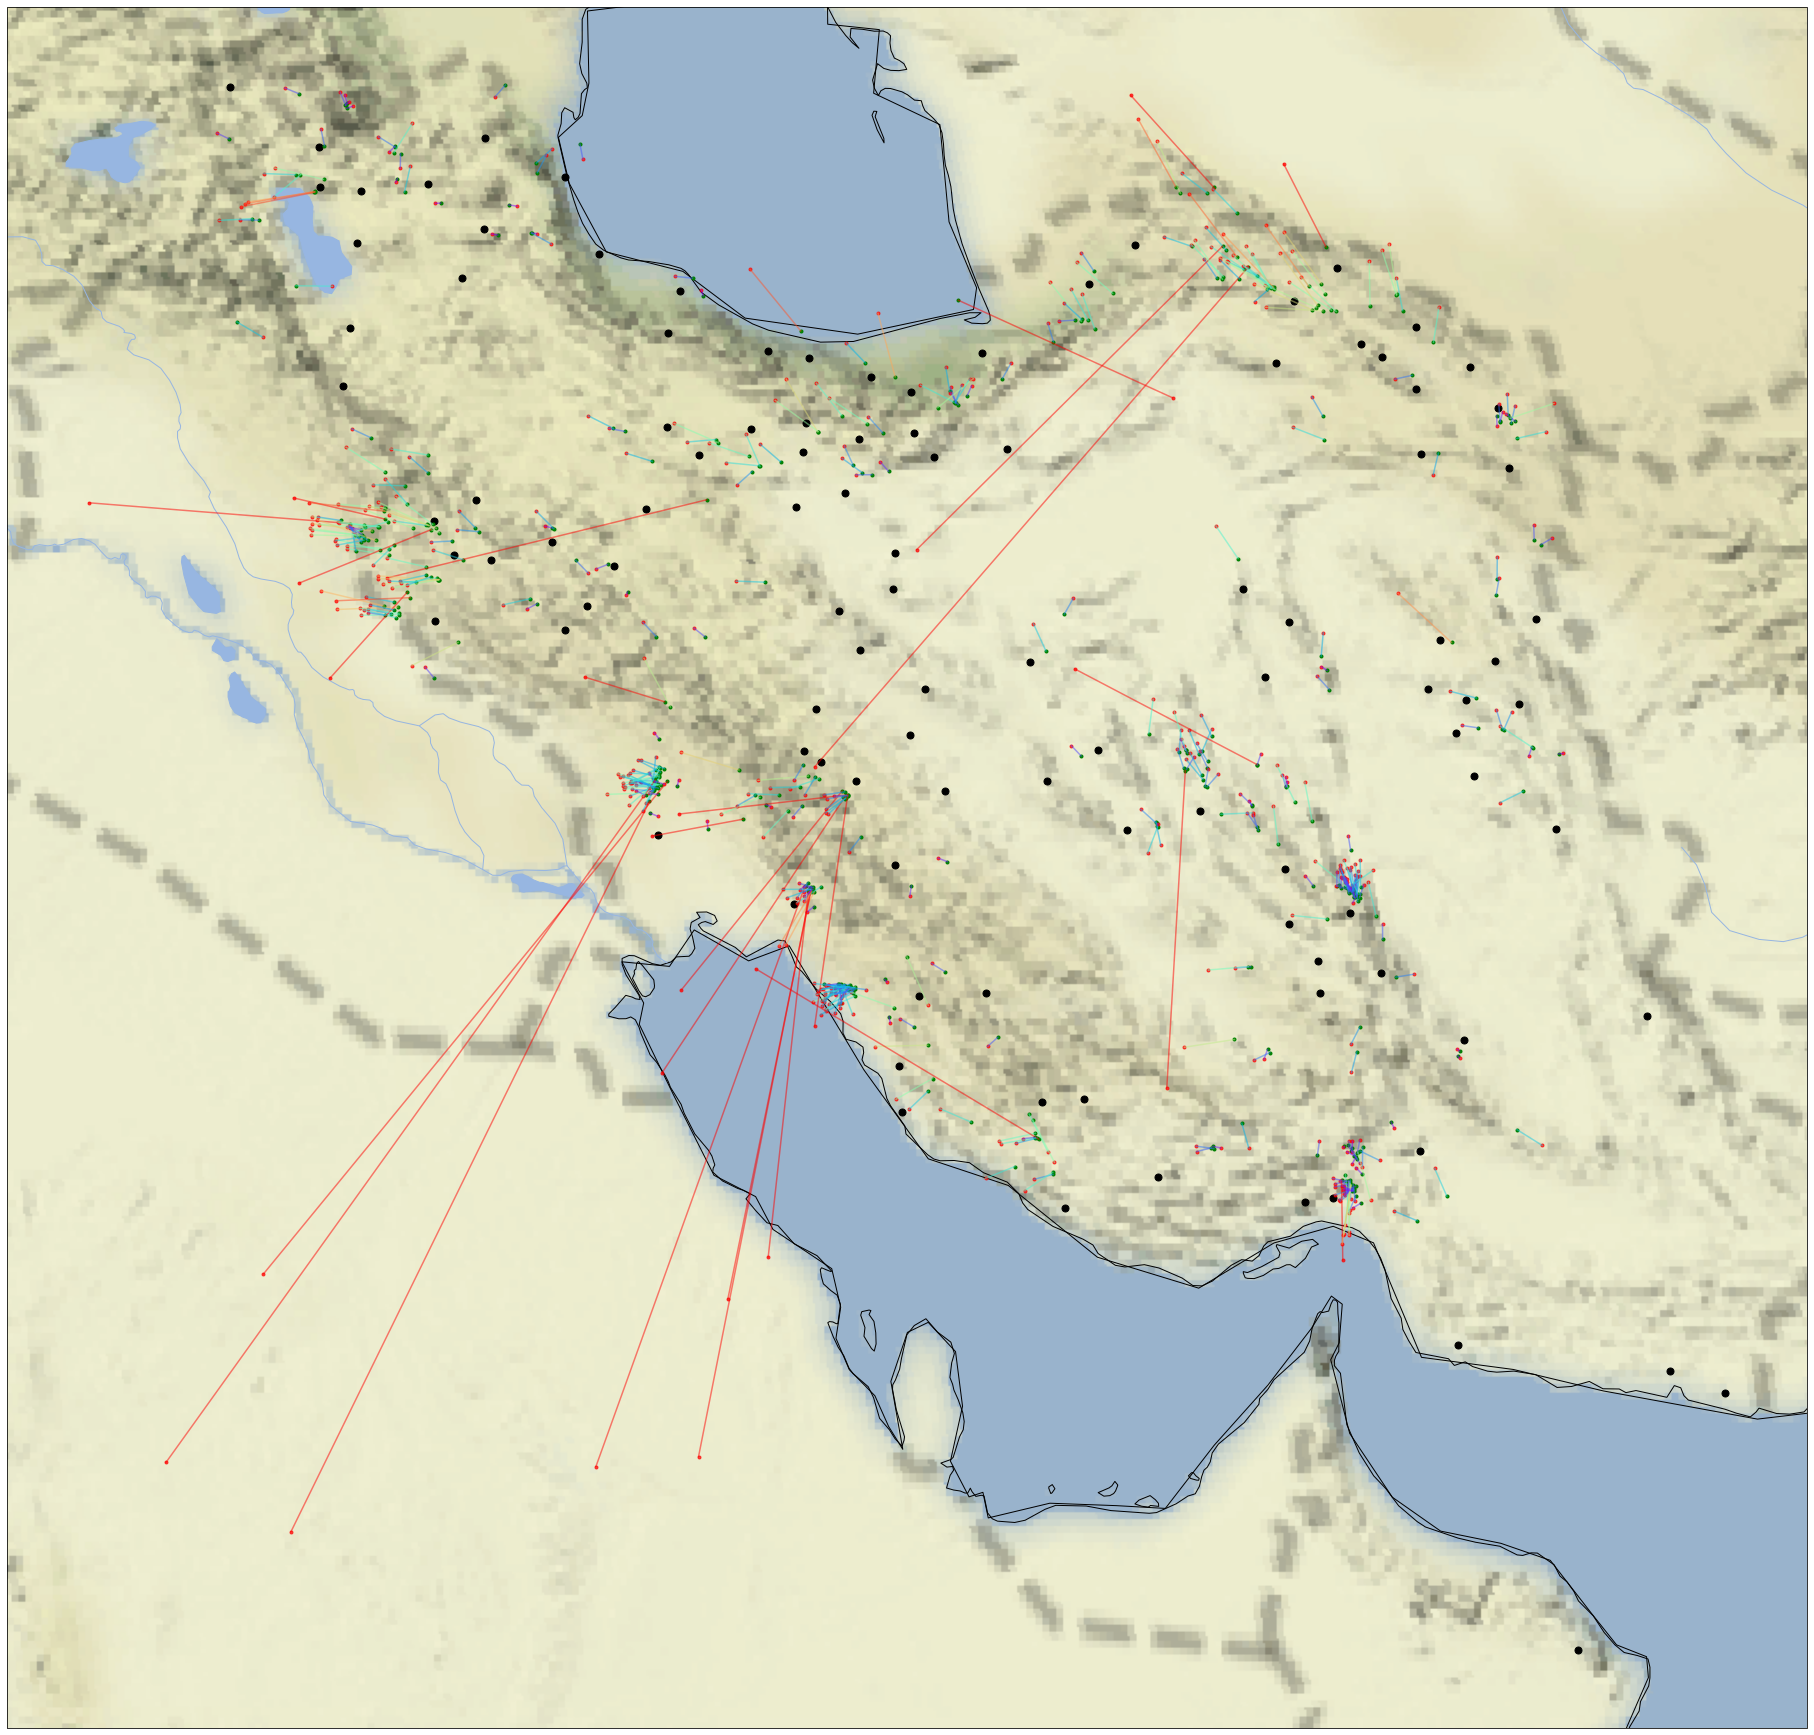

-----------------------------
Consolidated summary for: ./Models/Batch Error E076 L0.0965 A0.9725 P0.9514 R0.9573 HL81.4 VL0.0339 VA0.9807 VP0.9736 VR0.9796 VHL75.6.h5
File	AHM	 Location
00    93.84    52.51


In [5]:
#MatrixLink
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from collections import deque
from math import ceil
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from tensorflow.keras.models import load_model
from obspy import UTCDateTime
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import squareform
from Utils import nzBCE, nzMSE1, nzMSE2, nzHaversine, nzAccuracy, nzPrecision, nzRecall, nzTime, evaluate

# Build permutation lists and matrices to predict on
def permute(X):
    outerWindow = params['associationWindow']
    minArrivals = params['minArrivals']
    maxArrivals = params['maxArrivals']
    edgeWindow = outerWindow/5
    numWindows = ceil((X[:,2].max() + edgeWindow*2) / edgeWindow)
    start = -edgeWindow
    
#     X_perm = [[start, start+outerWindow] for start in range(int(-edgeWindow),(numWindows-1)*int(edgeWindow),int(edgeWindow))]
#     X_perm = [[perm[0][:maxArrivals], perm[1]] for perm in [[np.where((X[:,2] >= window[0]) & (X[:,2] < window[1]))[0],window[0]] for window in X_perm] if len(perm[0]) >= minArrivals]
#     innerWindows = [window[1]+edgeWindow for window in X_perm]
#     X_perm = [perm[0] for perm in X_perm]
#     X_test = np.stack([np.concatenate((X[X_perm[perm]], np.zeros((maxArrivals - len(X_perm[perm]), 5)))) for perm in range(len(X_perm))])
#     for i in range(len(X_perm)):
#         X_test[i,:len(X_perm[i]),2] -= X_test[i,0,2]
#     X_test[:,:,2] /= params['timeNormalize']
#     return X_perm, X_test, innerWindows

    innerWindows = deque()
    X_perm = deque()
    for window in range(numWindows):
        print('\rCreating permutations... ' + str(window) + ' / ' + str(numWindows), end='')
        end = start+outerWindow
        windowArrivals = np.where((X[:,2] >= start) & (X[:,2] < end))[0]
        start += edgeWindow
        if len(windowArrivals) >= minArrivals:
            X_perm.append(windowArrivals[:maxArrivals])
            innerWindows.append(start)
    X_test = np.zeros((len(X_perm),maxArrivals,5))
    for i in range(len(X_perm)):
        X_test[i,:len(X_perm[i])] = X[X_perm[i]]
        X_test[i,:len(X_perm[i]),2] -= X_test[i,0,2]
    X_test[:,:,2] /= params['timeNormalize']
    return X_perm, X_test, innerWindows

def buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows):
    # Get clusters for predicted matrix at index i
    def cluster(i):
        valids = np.where(X_test[i][:,-1])[0]
        validPreds = Y_pred[0][i][valids,:len(valids)]
        L = 1-((validPreds.T + validPreds)/2)
        np.fill_diagonal(L,0)
        return fcluster(ward(squareform(L)), params['clusterStrength'], criterion='distance')

    innerWindow = params['associationWindow'] * (3/5)
    minArrivals = params['minArrivals']
    catalogue = pd.DataFrame(columns=labels.columns)
#     events = deque()
    evid = 1
    created = 1
    for window in range(len(X_perm)):
        clusters = cluster(window)
        for c in np.unique(clusters):
            pseudoEventIdx = np.where(clusters == c)[0]
            pseudoEvent = X_perm[window][pseudoEventIdx]
            if len(pseudoEvent) >= minArrivals:
                event = X[pseudoEvent]
                # check for containment within inner window
                contained = (event[0,2] >= innerWindows[window]) & (event[-1,2] <= (innerWindows[window]+innerWindow))
                if contained:
                    candidate = labels.iloc[pseudoEvent].copy()
                    try:
                        candidate['ETIME'] = candidate.TIME.min() + np.median(Y_pred[3][window][pseudoEventIdx][:]*params['timeNormalize'])
                    except:
                        candidate['ETIME'] = -1
                    candidate['PLAT'] = Y_pred[1][window][pseudoEventIdx][:,0]*latRange+extents[0]
                    candidate['PLON'] = Y_pred[1][window][pseudoEventIdx][:,1]*lonRange+extents[2]
#                     candidate['LAT'] = np.median(Y_pred[1][window][pseudoEventIdx][:,0])*latRange+extents[0]
#                     candidate['LON'] = np.median(Y_pred[1][window][pseudoEventIdx][:,1])*lonRange+extents[2]
                    candidate['LAT'] = np.median(candidate.PLAT)
                    candidate['LON'] = np.median(candidate.PLON)
                    # check for existence in catalogue
                    overlap = candidate.ARID.isin(catalogue.ARID).sum()
                    if overlap == 0:
                        print("\rPromoting event " + str(created), end='')
#                         events.append(pseudoEvent)
                        candidate.EVID = evid
                        catalogue = pd.concat([catalogue,candidate])
                        evid += 1
                        created += 1
                    elif len(pseudoEvent) > overlap:
                        catalogue.drop(catalogue[catalogue.ARID.isin(candidate.ARID)].index, inplace=True)
                        candidate.EVID = evid
                        catalogue = pd.concat([catalogue,candidate])
                        evid += 1
    catalogue = catalogue.groupby('EVID').filter(lambda x: len(x) >= minArrivals)
    print()
    return catalogue

def matrixLink(X, labels, denoise=False):
    print("Creating permutations... ", end='')
    X_perm, X_test, innerWindows = permute(X)
    print("\nMaking initial predictions... ", end='')
    Y_pred = model.predict(X_test) if oneHot else model.predict({"phase": X_test[:,:,3], "numerical_features": X_test[:,:,[0,1,2,4]]})
    if denoise:
        print("\nEliminating noise and predicting again... ", end='')
        for _ in range(3):
            valids = deque()
            for i in range(len(X_perm)):
#                 valid = np.where(Y_pred[2][i] < 0.008)[0]
#                 valids.append(X_perm[i][valid[valid < len(X_perm[i])]])
                noise = np.where(Y_pred[2][i] > 0.008)[0]
                valids.append(np.delete(X_perm[i], noise[noise < len(X_perm[i])]))
            valids = np.array(list(set(np.concatenate(valids))))
            X = X[valids]
            labels = labels.iloc[valids]

            X_perm, X_test, innerWindows = permute(X)
            Y_pred = model.predict(X_test) if oneHot else model.predict({"phase": X_test[:,:,3], "numerical_features": X_test[:,:,[0,1,2,4]]})
    print("clustering and building events...")
    catalogue = buildEvents(X, labels, X_perm, X_test, Y_pred, innerWindows)
    return catalogue

def processInput(oneHot = False):
    print("Reading input file... ", end='')
    X = []
    labels = []
    for i, r in inputs.iterrows(): # I can do this better
        phase = phases[r.PHASE]
        time = UTCDateTime(r.TIME)
        lat = abs((r.ST_LAT - extents[0]) / latRange)
        lon = abs((r.ST_LON - extents[2]) / lonRange)
        otime = time - UTCDateTime(0)
        try:
            if oneHot:
                arrival = [lat, lon, otime, 0, 0, 0, 0, 1]
                arrival[3+phase] = 1
            else:
                arrival = [lat, lon, otime, phase, 1]
            X.append(arrival)
            labels.append(r)
        except Exception as e:
            print(e)
    X = np.array(X)
    idx = np.argsort(X[:,2])
    X = X[idx,:]
    X[:,2] -= X[0,2]
    labels = pd.DataFrame([labels[i] for i in idx])
    print("%d arrivals found" % len(labels))
    return X, labels

if __name__ == "__main__":
    pd.options.display.float_format = "{:.2f}".format
#     with open("Parameters.json", "r") as f:
#         params = json.load(f)
    phases = params['phases']
    extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
    latRange = abs(extents[1] - extents[0])
    lonRange = abs(extents[3] - extents[2])
    model = load_model(params['model'], custom_objects={'nzBCE':nzBCE, 'nzMSE':nzMSE2, 'nzMSE1':nzMSE1, 'nzMSE2':nzMSE2, 'nzHaversine':nzHaversine, 'nzPrecision':nzPrecision, 'nzRecall':nzRecall, 'nzAccuracy':nzAccuracy, 'nzTime':nzTime}, compile=True)

    inFiles = ['./Inputs/S1 00.gz']
#     inFiles = ['./Inputs/S1 50.gz', './Inputs/S1 25.gz', './Inputs/S1 15.gz', './Inputs/S1 00.gz']
    oneHot = False
    denoise = False
    evals = {file:[] for file in inFiles}
    for i in range(len(inFiles)):
        inputs = pd.read_pickle(inFiles[i]).sort_values(by=['TIME']).reset_index(drop=True)
        params['evalInFile'] = inFiles[i]
        start = inputs[inputs.TIME >= inputs.TIME.quantile(.8)].index[0]
        end = inputs[inputs.TIME >= inputs.TIME.quantile(.825)].index[0]
        inputs = inputs[start:end]

        X, labels = processInput(oneHot)
        outputs = matrixLink(X, labels, denoise)
        outputs.to_pickle(params['evalOutFile'])
        evals[inFiles[i]] = evaluate(params, inputs, outputs, verbose=False)

    print("Consolidated summary for:", params['model'])
    print('File\tAHM\t Location')
    for file in evals.keys():
        print(file[-5:-3], "{:8.2f}".format(evals[file][0]), "{:8.2f}".format(evals[file][1]))

In [6]:
def permute(X):
    windowSize = params['associationWindow']
    minArrivals = params['minArrivals']
    maxArrivals = params['maxArrivals']
    numWindows = ceil((X[:,2].max() / (windowSize/2)))
    start = 0

    windows = deque()
    X_perm = deque()
    for window in range(numWindows):
        print('\rCreating permutations... ' + str(window+1) + ' / ' + str(numWindows), end='')
        end = start+windowSize
        windowArrivals = np.where((X[:,2] >= start) & (X[:,2] < end))[0]
        X_perm.append(windowArrivals[:maxArrivals])
        windows.append(start)
        start += windowSize/2
    X_test = np.zeros((len(X_perm),maxArrivals,5))
    for i in range(len(X_perm)):
        X_test[i,:len(X_perm[i])] = X[X_perm[i]]
        X_test[i,:len(X_perm[i]),2] -= X_test[i,0,2]
    X_test[:,:,2] /= params['timeNormalize']
    return X_perm, X_test, windows

def buildEvents(X, labels, X_perm, X_test, Y_pred, windows):
    # Get clusters for predicted matrix at index i
    def cluster(i):
        valids = np.where(X_test[i][:,-1])[0]
        if len(valids) < 2:
            return None
        validPreds = Y_pred[0][i][valids,:len(valids)]
        L = 1-((validPreds.T + validPreds)/2)
        np.fill_diagonal(L,0)
        return fcluster(ward(squareform(L)), params['clusterStrength'], criterion='distance')

    minArrivals = params['minArrivals']
    catalogue = pd.DataFrame(columns=labels.columns)
    evid = 1
    created = 1
    for window in range(len(X_perm)):
        clusters = cluster(window)
        if clusters is None:
            continue
        for c in np.unique(clusters):
            pseudoEventIdx = np.where(clusters == c)[0]
            pseudoEvent = X_perm[window][pseudoEventIdx]
            if len(pseudoEvent) >= minArrivals:
                event = labels.iloc[pseudoEvent].copy()
                try:
                    event['ETIME'] = event.TIME.min() + np.median(Y_pred[2][window][pseudoEventIdx][:]*params['timeNormalize'])
                except:
                    event['ETIME'] = -1
                event['PLAT'] = Y_pred[1][window][pseudoEventIdx][:,0]*latRange+extents[0]
                event['PLON'] = Y_pred[1][window][pseudoEventIdx][:,1]*lonRange+extents[2]
                event['LAT'] = np.median(event.PLAT)
                event['LON'] = np.median(event.PLON)
                event.EVID = evid
                event['WINDOW'] = window
                evid += 1
                catalogue = pd.concat([catalogue, event])
        catalogue = catalogue.sort_values(by="TIME").reset_index(drop=True)
    return catalogue
                
#                 overlap = candidate.ARID.isin(catalogue.ARID).sum()
#                 if overlap == 0:
#                     print("\rPromoting event " + str(created), end='')
# #                         events.append(pseudoEvent)
#                     candidate.EVID = evid
#                     catalogue = catalogue.append(candidate)
#                     evid += 1
#                     created += 1
#     catalogue = catalogue.groupby('EVID').filter(lambda x: len(x) >= minArrivals)
#     print()
#     return catalogue

Reading input file... 5113 arrivals found
Matching event 509 / 509        6872        
Evaluating event 509 / 509                
-----------------------------
IoU evaluation for events with at least 5 arrivals for model ./Models/Batch Error E076 L0.0965 A0.9725 P0.9514 R0.9573 HL81.4 VL0.0339 VA0.9807 VP0.9736 VR0.9796 VHL75.6.h5
Parameters - evalInFile: ./Inputs/S1 00.gz	 maxArrivals: 50	 associationWindow: 300	 clusterStrength: 0.9
Totals/Average IoU: 4714 / 5009 = 0.9411060091834698
Precision: 0.9966173361522199
Recall: 0.9420463629096723
F1: 0.9685637970002055
Fake Arrivals: 0 / 0
Created / Actual Events: 509 / 506
Missed Events: 2
Merged Events: 11
Fake Events: 0
Arbitrary Health Measure: 90.256717024708

Location Errors Summary
Mean:   71.87
STD:   162.94
Min:     1.20
25%:    19.04
50%:    29.74
75%:    49.04
Max:  1197.59

Time Errors Summary
Mean:1521851243.69
STD:313923.51
Min:1521390734.00
25%:1521554836.00
50%:1521810867.00
75%:1522192822.00
Max:1522421500.00


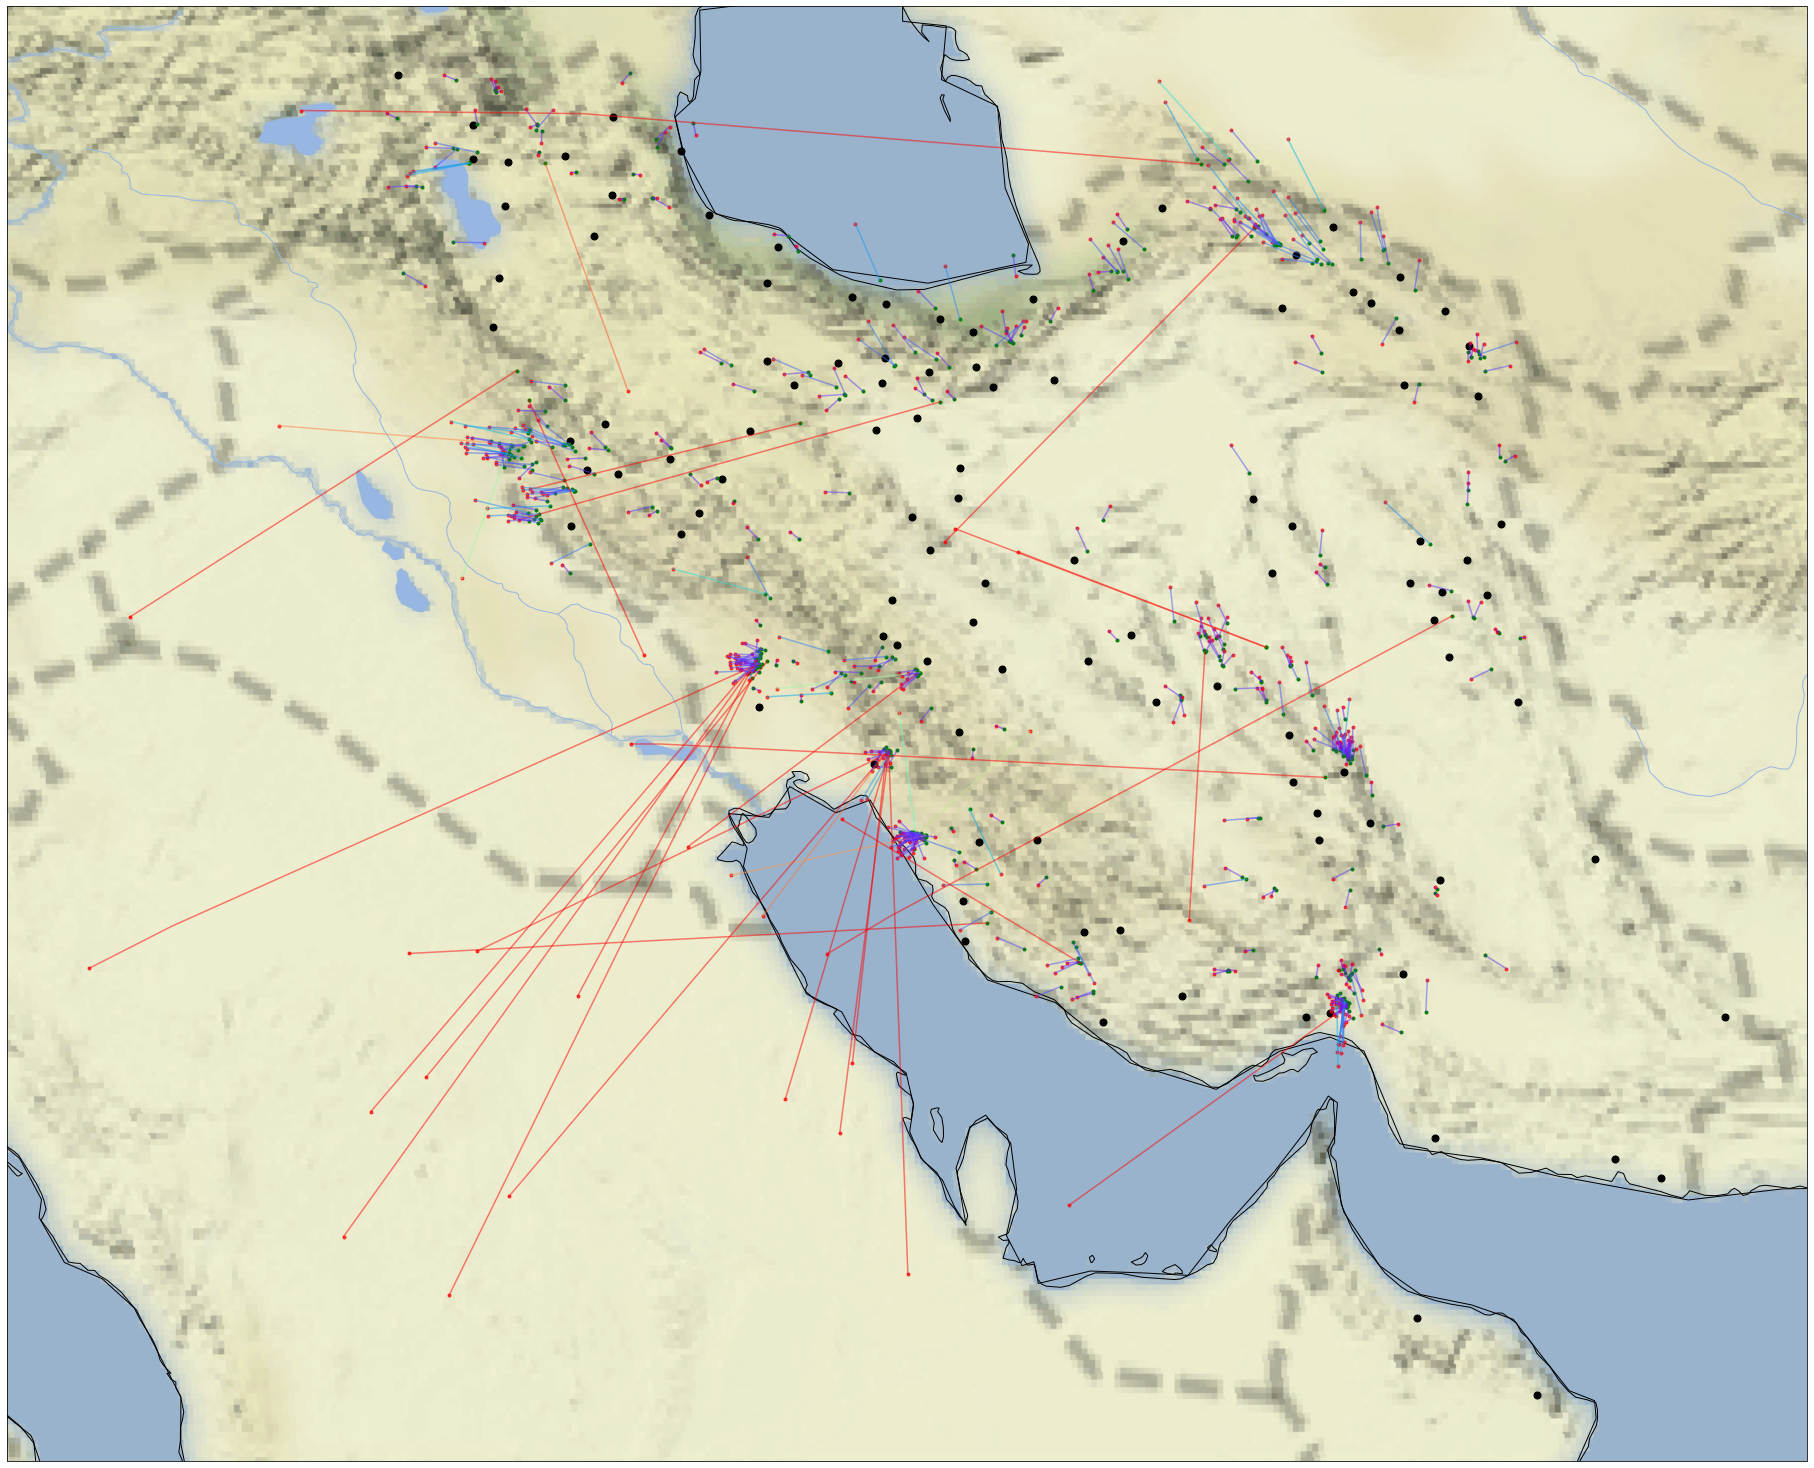

-----------------------------


[90.256717024708, 71.870743134477365]

In [7]:
pd.options.display.float_format = "{:.2f}".format
phases = params['phases']
extents = np.array(list(params['extents'][params['location']].values())+[params['maxDepth'],params['maxStationElevation']])
latRange = abs(extents[1] - extents[0])
lonRange = abs(extents[3] - extents[2])
model = load_model(params['model'], custom_objects={'nzBCE':nzBCE, 'nzMSE':nzMSE2, 'nzMSE1':nzMSE1, 'nzMSE2':nzMSE2, 'nzHaversine':nzHaversine, 'nzPrecision':nzPrecision, 'nzRecall':nzRecall, 'nzAccuracy':nzAccuracy, 'nzTime':nzTime}, compile=True)

inFiles = ['./Inputs/S1 00.gz']
oneHot = False
denoise = False
i=0
inputs = pd.read_pickle(inFiles[i]).sort_values(by=['TIME']).reset_index(drop=True)
params['evalInFile'] = inFiles[i]
start = inputs[inputs.TIME >= inputs.TIME.quantile(.8)].index[0]
end = inputs[inputs.TIME >= inputs.TIME.quantile(.825)].index[0]
inputs = inputs[start:end]

X, labels = processInput(oneHot)
X_perm, X_test, windows = permute(X)
Y_pred = model.predict({"phase": X_test[:,:,3], "numerical_features": X_test[:,:,[0,1,2,4]]})

catalogueb = buildEvents(X, labels, X_perm, X_test, Y_pred, windows)

catalogue = catalogueb.copy()
associationWindow = params['associationWindow']
minOverlap = 3
for window in catalogue.WINDOW.unique():
    for oldEvid, oldArrivals in catalogue[catalogue.WINDOW == window].groupby("EVID"):
        maxOverlap = 0
        bestMerge = None
        for newEvid, newArrivals in catalogue[catalogue.WINDOW == window+1].groupby("EVID"):
            overlap = len(newArrivals[newArrivals.ARID.isin(oldArrivals.ARID)])
            if overlap > maxOverlap:
                maxOverlap = overlap
                bestMerge = (oldEvid, newEvid)
        if bestMerge is not None:
            oldArrivals = catalogue[catalogue.EVID == bestMerge[0]]
            newArrivals = catalogue[catalogue.EVID == bestMerge[1]]
            overlappingArrivals = newArrivals.loc[newArrivals.ARID.isin(oldArrivals.ARID)].index
            if maxOverlap < minOverlap:
                # print(bestMerge, "Under minOverlap")
                catalogue.drop(overlappingArrivals, inplace=True)
            #check for length
            elif abs(newArrivals.TIME.max() - oldArrivals.TIME.min()) > associationWindow:
                #TODO: Only merge up to the maximum event length
                # print(bestMerge, "Over maximum duration")
                catalogue.drop(overlappingArrivals, inplace=True)
            else:
                catalogue.loc[newArrivals.index, 'EVID'] = bestMerge[0]
                catalogue.drop(overlappingArrivals, inplace=True)
                # print(bestMerge, "Merged")
catalogue.drop_duplicates(['ARID'], inplace = True)
catalogue.sort_values('TIME', inplace = True)
evaluate(params, inputs, catalogue, verbose=False)

In [278]:
catalogue[catalogue.ARID == 49458505]

,STA,TIME,ARID,PHASE,ST_LAT,ST_LON,ST_ELEV,ORID,EV_TIME,EVID,EV_LAT,EV_LON,EV_DEPTH,MB,ETIME,PLAT,PLON,LAT,LON,WINDOW
7411,DOB,1522237809,49458505,Pn,33.79,48.18,1.95,4959663,1522237776,829,31.91,48.70,20.10,3.80,-1.00,29.61,46.29,27.66,45.41,5646.00
7412,DOB,1522237809,49458505,Pn,33.79,48.18,1.95,4959663,1522237776,826,31.91,48.70,20.10,3.80,-1.00,25.63,41.42,26.20,42.18,5645.00
